In [1]:
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from heterogp.latent import Latent
from gpflow import settings
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import tensorflow as tf



/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


# Some helper functions

In [2]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
#         logging.warning(self.model)
        
def run_with_adam(model, lr,iterations, callback=None):
    
    adam = AdamOptimizer(lr).make_optimize_action(model)
    
    actions = [adam]#natgrad,
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

# Define some data with input-dependent noise

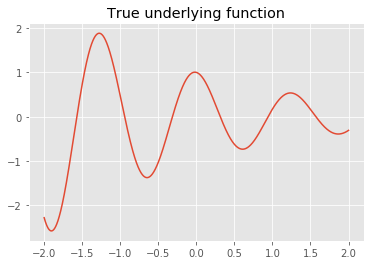

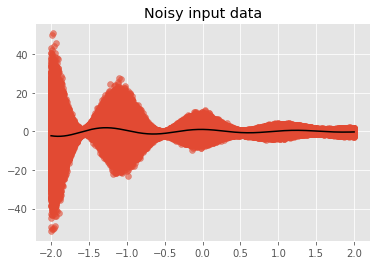

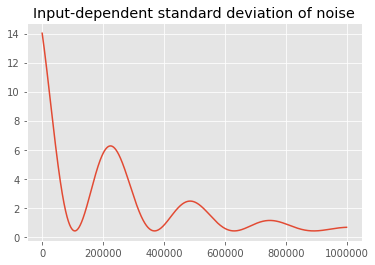

In [ ]:
def func(X):
    return np.cos(5*X)*np.exp(-X/2)

N = 1000000
X = np.linspace(-2,2,N)[:,None]
noise = 4*np.abs(0.25*(np.cos(6*X)+1)*np.exp(-X) + 0.1)
Y = func(X) + noise*np.random.normal(size=X.shape)

plt.plot(X[:,0],func(X)[:,0],alpha=1.)
plt.title("True underlying function")
plt.show()

plt.scatter(X[:,0],Y[:,0],alpha=0.6)
plt.plot(X[:,0],func(X)[:,0],alpha=1.,c='black')
plt.title("Noisy input data")
plt.show()
plt.title("Input-dependent standard deviation of noise")
plt.plot(noise)
plt.show()

# Vanilla solution

In [4]:
from gpflow.models import SVGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        # Define the likelihood
        likelihood = gp.likelihoods.Gaussian()
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = SVGP(X, Y, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=100,
                     num_latent = 1, 
                     num_data=None,
                     whiten=False,
                    Z=Z)
        model.compile()
    
    run_with_adam(model,1e-3,iterations, PrintAction(model,"Adam"))
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X)
    

2018-05-22 15:01:16,205 Adam: iteration 0 likelihood -48382334.9104
2018-05-22 15:01:16,330 Adam: iteration 1 likelihood -50544948.3120
2018-05-22 15:01:16,393 Adam: iteration 2 likelihood -55503689.5573
2018-05-22 15:01:16,436 Adam: iteration 3 likelihood -50724393.4589
2018-05-22 15:01:16,461 Adam: iteration 4 likelihood -46579950.7148
2018-05-22 15:01:16,478 Adam: iteration 5 likelihood -48859455.1404
2018-05-22 15:01:16,527 Adam: iteration 6 likelihood -47795616.8849
2018-05-22 15:01:16,578 Adam: iteration 7 likelihood -47158373.2946
2018-05-22 15:01:16,608 Adam: iteration 8 likelihood -46997782.6936
2018-05-22 15:01:16,625 Adam: iteration 9 likelihood -48412513.7257
2018-05-22 15:01:16,644 Adam: iteration 10 likelihood -48770951.3421
2018-05-22 15:01:16,680 Adam: iteration 11 likelihood -48886805.4512
2018-05-22 15:01:16,752 Adam: iteration 12 likelihood -49589852.8229
2018-05-22 15:01:16,787 Adam: iteration 13 likelihood -54087001.8300
2018-05-22 15:01:16,810 Adam: iteration 14 l

2018-05-22 15:01:20,090 Adam: iteration 119 likelihood -33685215.4843
2018-05-22 15:01:20,115 Adam: iteration 120 likelihood -34749407.7045
2018-05-22 15:01:20,135 Adam: iteration 121 likelihood -34210054.3602
2018-05-22 15:01:20,152 Adam: iteration 122 likelihood -33964770.9918
2018-05-22 15:01:20,177 Adam: iteration 123 likelihood -36275762.9090
2018-05-22 15:01:20,198 Adam: iteration 124 likelihood -34110018.7004
2018-05-22 15:01:20,219 Adam: iteration 125 likelihood -34620805.3596
2018-05-22 15:01:20,244 Adam: iteration 126 likelihood -34378610.0771
2018-05-22 15:01:20,266 Adam: iteration 127 likelihood -34860574.8055
2018-05-22 15:01:20,290 Adam: iteration 128 likelihood -36810495.0093
2018-05-22 15:01:20,321 Adam: iteration 129 likelihood -34273979.7778
2018-05-22 15:01:20,348 Adam: iteration 130 likelihood -33811644.1106
2018-05-22 15:01:20,376 Adam: iteration 131 likelihood -34074498.8579
2018-05-22 15:01:20,396 Adam: iteration 132 likelihood -36337458.0415
2018-05-22 15:01:20,

2018-05-22 15:01:23,801 Adam: iteration 237 likelihood -26090595.8029
2018-05-22 15:01:23,908 Adam: iteration 238 likelihood -23766967.7250
2018-05-22 15:01:24,001 Adam: iteration 239 likelihood -27130953.3084
2018-05-22 15:01:24,047 Adam: iteration 240 likelihood -28451111.7826
2018-05-22 15:01:24,078 Adam: iteration 241 likelihood -29876060.6723
2018-05-22 15:01:24,124 Adam: iteration 242 likelihood -27802981.3337
2018-05-22 15:01:24,151 Adam: iteration 243 likelihood -25818593.4605
2018-05-22 15:01:24,179 Adam: iteration 244 likelihood -26673684.0843
2018-05-22 15:01:24,209 Adam: iteration 245 likelihood -30617339.3904
2018-05-22 15:01:24,228 Adam: iteration 246 likelihood -30899579.9986
2018-05-22 15:01:24,256 Adam: iteration 247 likelihood -29156377.9302
2018-05-22 15:01:24,304 Adam: iteration 248 likelihood -26018887.4337
2018-05-22 15:01:24,359 Adam: iteration 249 likelihood -26210449.5888
2018-05-22 15:01:24,395 Adam: iteration 250 likelihood -24570569.9470
2018-05-22 15:01:24,

2018-05-22 15:01:28,258 Adam: iteration 355 likelihood -22549741.0242
2018-05-22 15:01:28,282 Adam: iteration 356 likelihood -21799903.4330
2018-05-22 15:01:28,306 Adam: iteration 357 likelihood -22063100.0545
2018-05-22 15:01:28,328 Adam: iteration 358 likelihood -20536734.9474
2018-05-22 15:01:28,347 Adam: iteration 359 likelihood -20536104.3655
2018-05-22 15:01:28,371 Adam: iteration 360 likelihood -19940129.7308
2018-05-22 15:01:28,391 Adam: iteration 361 likelihood -22566711.5146
2018-05-22 15:01:28,408 Adam: iteration 362 likelihood -20801831.9070
2018-05-22 15:01:28,456 Adam: iteration 363 likelihood -19008255.3158
2018-05-22 15:01:28,485 Adam: iteration 364 likelihood -18208201.3767
2018-05-22 15:01:28,541 Adam: iteration 365 likelihood -26211637.5371
2018-05-22 15:01:28,578 Adam: iteration 366 likelihood -17625025.3938
2018-05-22 15:01:28,619 Adam: iteration 367 likelihood -19552827.0457
2018-05-22 15:01:28,638 Adam: iteration 368 likelihood -23684024.9665
2018-05-22 15:01:28,

2018-05-22 15:01:32,505 Adam: iteration 473 likelihood -14181379.5281
2018-05-22 15:01:32,528 Adam: iteration 474 likelihood -14454917.5503
2018-05-22 15:01:32,545 Adam: iteration 475 likelihood -19614300.6591
2018-05-22 15:01:32,577 Adam: iteration 476 likelihood -16460361.4568
2018-05-22 15:01:32,611 Adam: iteration 477 likelihood -18087674.1090
2018-05-22 15:01:32,633 Adam: iteration 478 likelihood -18441678.9675
2018-05-22 15:01:32,651 Adam: iteration 479 likelihood -18565575.5235
2018-05-22 15:01:32,667 Adam: iteration 480 likelihood -16340553.8180
2018-05-22 15:01:32,686 Adam: iteration 481 likelihood -16424399.8843
2018-05-22 15:01:32,703 Adam: iteration 482 likelihood -15272796.6666
2018-05-22 15:01:32,729 Adam: iteration 483 likelihood -14047200.8465
2018-05-22 15:01:32,750 Adam: iteration 484 likelihood -17958447.5271
2018-05-22 15:01:32,811 Adam: iteration 485 likelihood -17255472.4421
2018-05-22 15:01:32,883 Adam: iteration 486 likelihood -17044349.3189
2018-05-22 15:01:32,

2018-05-22 15:01:36,224 Adam: iteration 591 likelihood -18632944.7741
2018-05-22 15:01:36,247 Adam: iteration 592 likelihood -12278920.6168
2018-05-22 15:01:36,274 Adam: iteration 593 likelihood -13881835.3013
2018-05-22 15:01:36,297 Adam: iteration 594 likelihood -13889747.6837
2018-05-22 15:01:36,327 Adam: iteration 595 likelihood -10895073.8473
2018-05-22 15:01:36,346 Adam: iteration 596 likelihood -12199548.7303
2018-05-22 15:01:36,374 Adam: iteration 597 likelihood -15498397.1302
2018-05-22 15:01:36,405 Adam: iteration 598 likelihood -13088059.7705
2018-05-22 15:01:36,433 Adam: iteration 599 likelihood -13293401.7151
2018-05-22 15:01:36,662 Adam: iteration 600 likelihood -15006221.1225
2018-05-22 15:01:36,686 Adam: iteration 601 likelihood -16668300.8098
2018-05-22 15:01:36,717 Adam: iteration 602 likelihood -12816982.5603
2018-05-22 15:01:36,759 Adam: iteration 603 likelihood -14632914.2425
2018-05-22 15:01:36,792 Adam: iteration 604 likelihood -16200175.5826
2018-05-22 15:01:36,

2018-05-22 15:01:40,085 Adam: iteration 709 likelihood -8980240.0434
2018-05-22 15:01:40,098 Adam: iteration 710 likelihood -14812429.7857
2018-05-22 15:01:40,114 Adam: iteration 711 likelihood -10722257.8679
2018-05-22 15:01:40,146 Adam: iteration 712 likelihood -8473663.6510
2018-05-22 15:01:40,162 Adam: iteration 713 likelihood -13878790.7948
2018-05-22 15:01:40,178 Adam: iteration 714 likelihood -9114120.2318
2018-05-22 15:01:40,194 Adam: iteration 715 likelihood -12699185.6077
2018-05-22 15:01:40,238 Adam: iteration 716 likelihood -17653618.8750
2018-05-22 15:01:40,255 Adam: iteration 717 likelihood -13546989.2433
2018-05-22 15:01:40,279 Adam: iteration 718 likelihood -9144122.1837
2018-05-22 15:01:40,319 Adam: iteration 719 likelihood -11451012.1180
2018-05-22 15:01:40,341 Adam: iteration 720 likelihood -8264899.7200
2018-05-22 15:01:40,373 Adam: iteration 721 likelihood -12890638.1694
2018-05-22 15:01:40,387 Adam: iteration 722 likelihood -10031469.3868
2018-05-22 15:01:40,418 A

2018-05-22 15:01:43,453 Adam: iteration 827 likelihood -10387416.1980
2018-05-22 15:01:43,469 Adam: iteration 828 likelihood -10690024.4328
2018-05-22 15:01:43,488 Adam: iteration 829 likelihood -7099333.7651
2018-05-22 15:01:43,549 Adam: iteration 830 likelihood -10374563.3952
2018-05-22 15:01:43,597 Adam: iteration 831 likelihood -10989215.6631
2018-05-22 15:01:43,651 Adam: iteration 832 likelihood -10117223.5359
2018-05-22 15:01:43,667 Adam: iteration 833 likelihood -8876809.7666
2018-05-22 15:01:43,690 Adam: iteration 834 likelihood -10811919.8691
2018-05-22 15:01:43,747 Adam: iteration 835 likelihood -10946454.3512
2018-05-22 15:01:43,781 Adam: iteration 836 likelihood -9090421.1983
2018-05-22 15:01:43,816 Adam: iteration 837 likelihood -7636691.1101
2018-05-22 15:01:43,838 Adam: iteration 838 likelihood -11972627.3258
2018-05-22 15:01:43,859 Adam: iteration 839 likelihood -9638094.5917
2018-05-22 15:01:43,881 Adam: iteration 840 likelihood -10415924.1687
2018-05-22 15:01:43,905 A

2018-05-22 15:01:47,813 Adam: iteration 946 likelihood -7916006.2744
2018-05-22 15:01:47,836 Adam: iteration 947 likelihood -7540277.3875
2018-05-22 15:01:47,857 Adam: iteration 948 likelihood -7525227.1282
2018-05-22 15:01:47,892 Adam: iteration 949 likelihood -6354732.9629
2018-05-22 15:01:47,922 Adam: iteration 950 likelihood -6145903.5314
2018-05-22 15:01:47,946 Adam: iteration 951 likelihood -9679965.7745
2018-05-22 15:01:47,970 Adam: iteration 952 likelihood -9918697.0021
2018-05-22 15:01:47,993 Adam: iteration 953 likelihood -10582770.7473
2018-05-22 15:01:48,018 Adam: iteration 954 likelihood -6766175.2422
2018-05-22 15:01:48,044 Adam: iteration 955 likelihood -6480313.3434
2018-05-22 15:01:48,067 Adam: iteration 956 likelihood -6194406.4513
2018-05-22 15:01:48,090 Adam: iteration 957 likelihood -7539217.1642
2018-05-22 15:01:48,150 Adam: iteration 958 likelihood -9440704.1654
2018-05-22 15:01:48,168 Adam: iteration 959 likelihood -9270186.9871
2018-05-22 15:01:48,188 Adam: ite

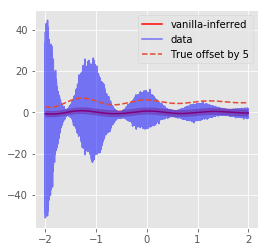

In [5]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar,alpha=1,c='r',label='vanilla-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar+np.sqrt(varstar)),
                 np.squeeze(ystar-np.sqrt(varstar)),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("vanilla.png")
plt.show()

# Define the HGP model and train

We will:
  - Define the latent GP that models the noise
  - Define heteroscedastic likelihood which uses the above latent
  - Define the HGP which has another independent latent modelling the
  underlying function
  - Finally, train with Adam and plot the results

In [ ]:
from heterogp.likelihoods import HeteroscedasticGaussian
from heterogp.hgp import HGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        
        # Define the (log) noise latent
        mean = gp.mean_functions.Constant(np.log(0.5))
        kern = gp.kernels.RBF(1)
        log_noise_latent = Latent(Z, mean, kern, num_latent=1, whiten=False, name=None)
        # Define the likelihood
        likelihood = HeteroscedasticGaussian(log_noise_latent)
        log_noise_latent
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = HGP(X, Y, Z, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=500,
                     num_latent = 1, 
                     num_samples=1,
                     num_data=None,
                     whiten=False)
        model.compile()
    from timeit import default_timer
    t0 = default_timer()
    run_with_adam(model,1e-3,iterations)
    print(default_timer() - t0)
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X, 100)
    # For plotting the noise
    hetero_noise = model.likelihood.compute_hetero_noise(X,100)

153.65456754600746


In [ ]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],hetero_noise[:,:,0].T,alpha=0.05,c='b')
# plt.title("Samples for the noise latent")
plt.plot(X[:,0],noise,label='actual-noise')
plt.yscale('log')
plt.legend()
plt.savefig("inferred_noise.png")
plt.show()

plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar.mean(0),alpha=1,c='r',label='hetero-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar.mean(0)+np.sqrt(varstar.mean(0))),
                 np.squeeze(ystar.mean(0)-np.sqrt(varstar.mean(0))),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("hetero_inferred.png")
plt.show()